# Generate a PV diagram using PVExtractor

In [307]:
import pylab as plt
import numpy as np
from astropy.visualization import quantity_support
from astropy import units as u
from astropy import wcs
from astropy.wcs import WCS
from astropy.io import fits
from astropy.coordinates import SkyCoord

# set so that these display properly on black backgrounds
plt.rcParams['figure.facecolor']='w'

from spectral_cube import SpectralCube
import aplpy

from pvextractor import extract_pv_slice, Path, PathFromCenter

### First use the scattered light image to get the vector along which we'll generate the PV diagram

In [308]:
# load in the PS1 g-band image which we need to identify the disk's midplane

gband_file = '/Users/kristina/Hamburgers/Draculas_Chivito/Pan-STARRS_fits_files/cutout_rings.v3.skycell.2537.088.stk.g.unconv.fits'
gband = fits.open(gband_file)

wcs_gband = WCS(gband[0].header)
gband_data = gband[0].data
gband_header = gband[0].header

#gband_header

In [309]:
# then load in the 12CO data cube which is needed to obtain the velocities

spectral_cube = SpectralCube.read('/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.briggs0.12CO.LSRK.im.image_modified_header.fits')

spectral_cube = spectral_cube.with_spectral_unit(unit=u.km/u.s, rest_value=230.538*u.GHz, velocity_convention='radio')
spectral_cube._unit = u.Jy/u.beam

spectral_cube

VaryingResolutionSpectralCube with shape=(60, 144, 144) and unit=Jy / beam:
 n_x:    144  type_x: RA---SIN  unit_x: deg    range:   347.406190 deg:  347.457880 deg
 n_y:    144  type_y: DEC--SIN  unit_y: deg    range:    67.384148 deg:   67.404009 deg
 n_s:     60  type_s: VRAD      unit_s: km / s  range:      -16.227 km / s:       5.202 km / s

In [311]:
# define the centtral point of the vector (I got the coordinates from CASA)
ra_cen = 347.4323*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=2.*u.arcsec)

pvdiagram = extract_pv_slice(cube=spectral_cube, path=Path, spacing=1.)

(23.0, 50.0)

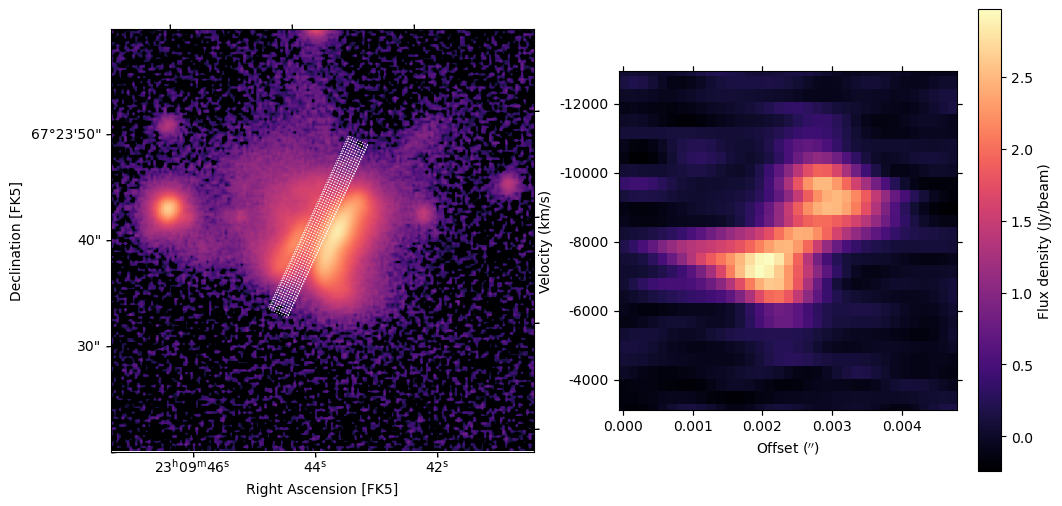

In [312]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_gband)

ax.imshow(gband_data, cmap='magma', norm=SymLogNorm(linthresh=1e1, linscale=0.001, vmin=-10, vmax=1e5))
Path.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)



# then show the PV diagram
ww = wcs.WCS(pvdiagram.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww)
im = ax.imshow(pvdiagram.data, cmap='magma')


#ax0 = ax.coords[0]
#ax0.set_format_unit(u.arcsec)
#ax1 = ax.coords[1]
#ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)
cb.set_label("Flux density (Jy/beam)")

ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)


ax.set_ylim(23, 50)




## Repeat the same analysis but now compute the PV diagram along the 12CO channel map

In [313]:
# load in the PS1 g-band image which we need to identify the disk's midplane

mom0_file = '/Users/kristina/Hamburgers/Draculas_Chivito/SMA/DraChi.briggs0.12CO.LSRK.im.image_M0.fits'
mom0 = fits.open(mom0_file)

wcs_mom0 = WCS(mom0[0].header)
mom0_data = mom0[0].data
mom0_header = mom0[0].header



/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


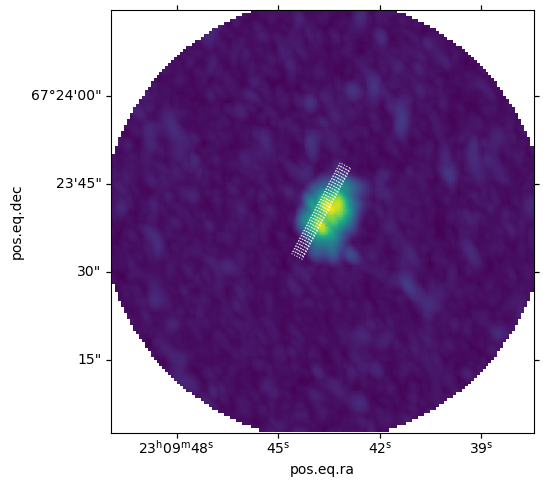

In [314]:
# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4323*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=2.*u.arcsec)


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection=spectral_cube.wcs.celestial)
ax.imshow(spectral_cube.max(axis=0).value)
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


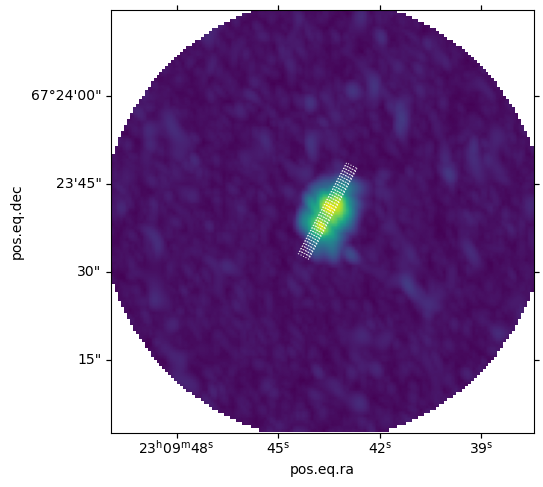

In [316]:
### Now adjust the right ascension such that it aligns with the "major axis" of the 12CO emission

# First, take the same vector as in the scattered light image (as this one safely constrains the position angle)
ra_cen = 347.4315*u.deg 
dec_cen = 67.3945*u.deg 

# Notes: The orientation of the final path will be such that for a position angle of zero, the path goes from South to North. 
# For a position angle of 90 degrees, the path will go from West to East.
# https://pvextractor.readthedocs.io/en/latest/api/pvextractor.PathFromCenter.html
Path2 = PathFromCenter(center=SkyCoord(ra_cen, dec_cen, frame='fk5'), length=18.*u.arcsec, angle=152*u.deg, sample=2, width=2.*u.arcsec)


plt.figure(figsize=(12,6))
ax = plt.subplot(121, projection=spectral_cube.wcs.celestial)
ax.imshow(spectral_cube.max(axis=0).value)
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)

In [533]:
### Now we can compute the pv diagram:

pvdiagram2 = extract_pv_slice(cube=spectral_cube, path=Path2, spacing=1.)

/Users/kristina/miniconda3/lib/python3.10/site-packages/radio_beam/multiple_beams.py:286: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"
/Users/kristina/miniconda3/lib/python3.10/site-packages/spectral_cube/spectral_cube.py:441: RuntimeWarning: All-NaN slice encountered
  out = function(self._get_filled_data(fill=fill,


(23.0, 50.0)

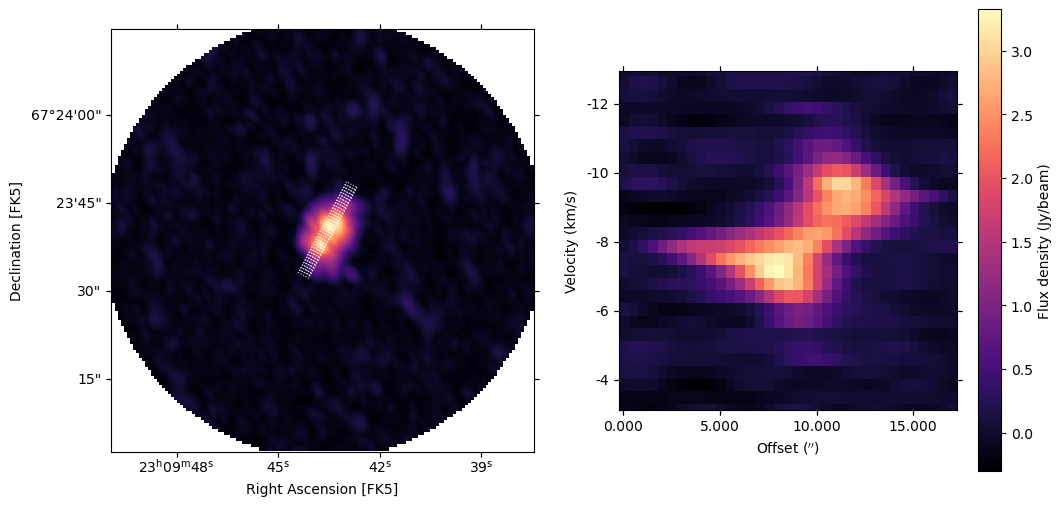

In [534]:
# plot the results and check if they make sense

from matplotlib.colors import SymLogNorm, LogNorm

plt.figure(figsize=(12,6))

# first show vector on PS1 g-band
ax = plt.subplot(121, projection=wcs_mom0)

ax.imshow(spectral_cube.max(axis=0).value, cmap='magma')
Path2.show_on_axis(ax=ax, spacing=1, edgecolor='w', linestyle=':', linewidth=0.75)


# then show the PV diagram
ww2 = wcs.WCS(pvdiagram2.header)
ax.set_xlabel(f"Right Ascension [FK5]")
ax.set_ylabel(f"Declination [FK5]")

ax = plt.subplot(122, projection=ww2)
im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(1.3)

ax.set_ylim(23, 50)

## Now overplot the Keplerian velocity profile for different disk masses

In [319]:
### First define Keplerian velocity

import astropy.constants as const
import astropy.units as u

def kepler(mass, radius, distance, inclination):
    """
    mass in solar masses
    radius in arcsec
    distance in pc
    inclination in degrees
    """
    G = const.G
    mass *= u.Msun
    physical_radius = (radius*distance)*u.au
    
    return np.sqrt(G*mass/physical_radius).to(u.km/u.s)*np.sin(inclination*u.deg)

/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


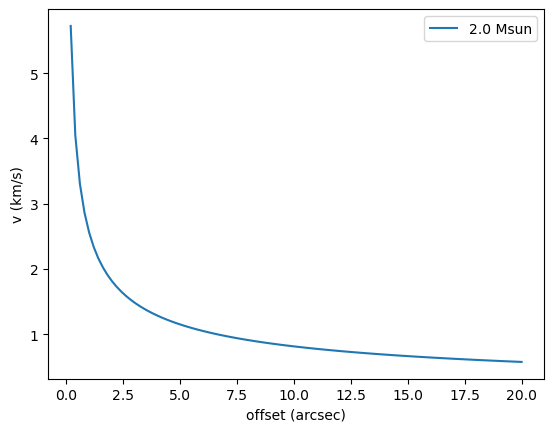

In [320]:
radii = np.linspace(0,20,100) #


plt.plot(radii, kepler(mass=2.0, radius=radii, distance=260., inclination=80.), label='2.0 Msun')

plt.xlabel('offset (arcsec)')
plt.ylabel('v (km/s)')
#plt.yscale('log')
plt.legend()
#plt.gca().invert_yaxis()


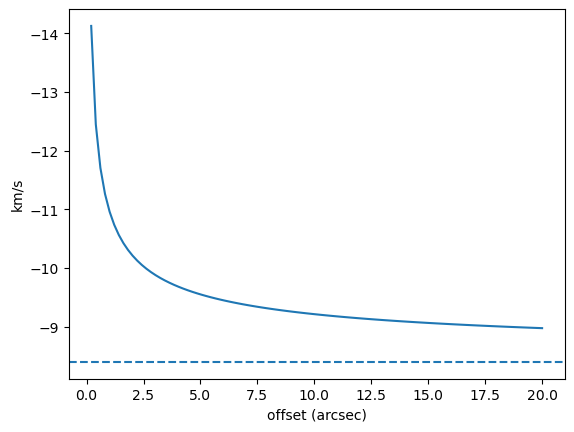

In [321]:
### Keep in mind that DraChi has a systemic velocity of -8.5 km/s, thus we need to shift v along the y-axis

radii = np.linspace(0,20,100) #

v_sys = -8.4*u.km/u.s # got this value from eddy

plt.plot(radii, v_sys-kepler(mass=2.0, radius=radii, distance=260., inclination=80.))
plt.axhline(v_sys.value, ls='--')

plt.xlabel('offset (arcsec)')
plt.ylabel('km/s')
#plt.yscale('log')
plt.gca().invert_yaxis()


### @ Josh: here is where I'm struggling, because ax.plot and ax.scatter only take pixel units as arguments, so I need to convert v and offset into pixel units. I've tried several ways but for some reason it's not working...

In [322]:
pvdiagram2.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   35                                                  
NAXIS2  =                   60                                                  
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                  1.0 / Pixel coordinate of reference point            
CRPIX2  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =   0.0001388888888889 / [deg] Coordinate increment at reference point  
CDELT2  =     -363.19867730252 / [m/s] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'm/s'                / Units of coordinate increment and value        
CTYPE1  = 'OFFSET'          

In [323]:
## y-Nullpunkt ist bei 5201.6146231858, i.e. dieser Wert muss zu allen anderen Werten dazu addiert werden

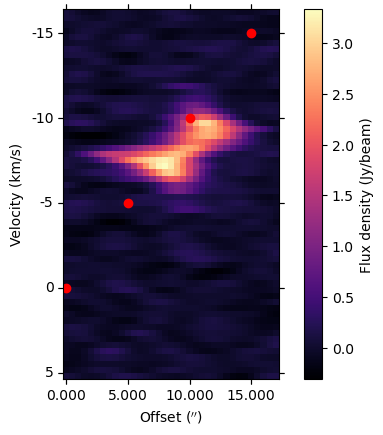

In [324]:
ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='magma')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
#ax.set_aspect(1)

y_zero = 5.2016146231858 # km/s
y_pixscale = 0.36319867699999997 # km/s per pixel
x_pixscale = 0.5 # arcsec per pixel

y_offset = y_zero/y_pixscale


ax.scatter(0/x_pixscale, 0/y_pixscale+y_offset, c='red')
ax.scatter(5/x_pixscale, -(-5/y_pixscale)+y_offset, c='red')
ax.scatter(10/x_pixscale, -(-10/y_pixscale)+y_offset, c='red')
ax.scatter(15/x_pixscale, -(-15/y_pixscale)+y_offset, c='red')


#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


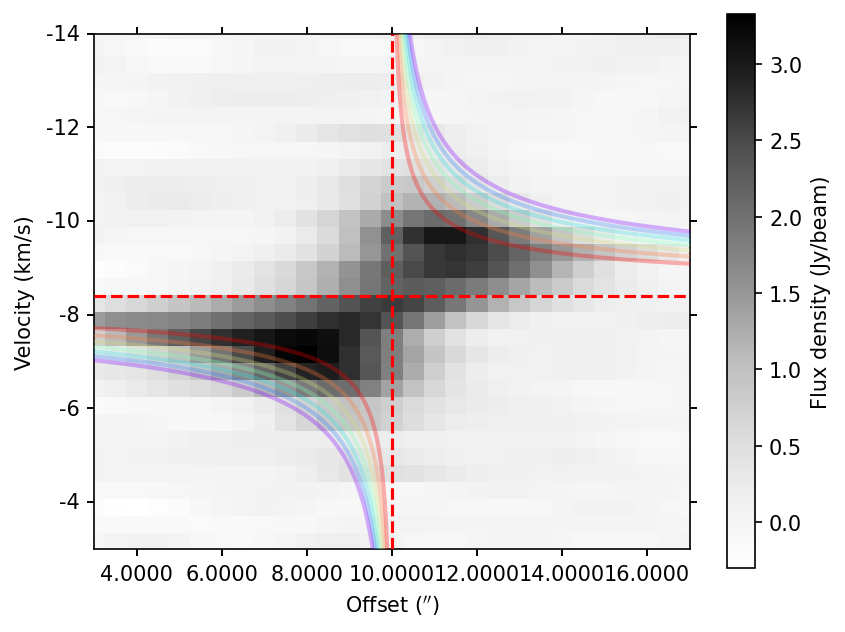

In [406]:
plt.figure(dpi=150)

ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='Greys')

ax0 = ax.coords[0]
ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
ax1.set_format_unit(u.km/u.s)
cb = plt.colorbar(mappable=im)

cb.set_label("Flux density (Jy/beam)")
ax.set_ylabel("Velocity (km/s)")
ax.set_xlabel("Offset ($''$)")
ax.set_aspect(0.8)

y_zero = 5.2016146231858 # km/s
y_pixscale = 0.36319867699999997 # km/s per pixel
x_pixscale = 0.5 # arcsec per pixel
ax.set_xlim(3/x_pixscale, 17/x_pixscale)
ax.set_ylim(3/y_pixscale+y_offset, 14/y_pixscale+y_offset)

y_offset = y_zero/y_pixscale
x_offset = 10/x_pixscale

radii_pos = np.linspace(0,20,1000)
radii_pixelscale = radii_pos/x_pixscale


plt.axhline(-(v_sys.value/y_pixscale)+y_offset, c='red', ls='--')
plt.axvline(x_offset, c='red', ls='--')

colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))

# rainbow_r colormap starts at red
masses = np.arange(1,4.5,0.5)
for el in range(len(masses)):
    ax.plot(radii_pixelscale+x_offset, -(v_sys.value/y_pixscale)+kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=260., inclination=80.).value/y_pixscale+y_offset, c=colors[el], alpha=0.3, lw=2)
    ax.plot(-radii_pixelscale+x_offset, -(v_sys.value/y_pixscale)-kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=260., inclination=80.).value/y_pixscale+y_offset, c=colors[el], alpha=0.3, lw=2)

#ax.plot(PVpix_neg, (v_sys-kepler(mass=2.0, radius=np.abs(PVpix_neg.value), distance=260., inclination=80.)))


#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

In [560]:
ww2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'OFFSET'  'VRAD'  
CRVAL : 0.0  5201.6146231858  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.0001388888888889  -363.19867730252  
NAXIS : 35  60

In [654]:
np.linspace(0,59,60)*-363.19867730252+5201.6146231858

array([  5201.61462319,   4838.41594588,   4475.21726858,   4112.01859128,
         3748.81991398,   3385.62123667,   3022.42255937,   2659.22388207,
         2296.02520477,   1932.82652746,   1569.62785016,   1206.42917286,
          843.23049556,    480.03181825,    116.83314095,   -246.36553635,
         -609.56421365,   -972.76289096,  -1335.96156826,  -1699.16024556,
        -2062.35892286,  -2425.55760017,  -2788.75627747,  -3151.95495477,
        -3515.15363207,  -3878.35230938,  -4241.55098668,  -4604.74966398,
        -4967.94834128,  -5331.14701859,  -5694.34569589,  -6057.54437319,
        -6420.74305049,  -6783.9417278 ,  -7147.1404051 ,  -7510.3390824 ,
        -7873.5377597 ,  -8236.73643701,  -8599.93511431,  -8963.13379161,
        -9326.33246892,  -9689.53114622, -10052.72982352, -10415.92850082,
       -10779.12717813, -11142.32585543, -11505.52453273, -11868.72321003,
       -12231.92188734, -12595.12056464, -12958.31924194, -13321.51791924,
       -13684.71659655, -

Text(0, 0.5, 'Velocity in m/s')

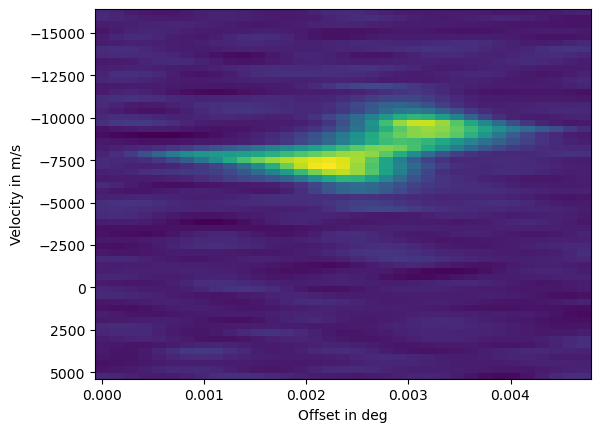

In [655]:
### 1 xpixel = 0.0001388888888889 deg
### 1 ypixel = -363.19867730252 m/s

x_arr = np.linspace(0,34,35)*0.0001388888888889

# y-Achse muss anhand der systemic velocity geshifted werden
y_arr = np.linspace(0,59,60)*-363.19867730252+5201.6146231858

xi, yi = np.meshgrid(x_arr, y_arr)
zi = pvdiagram2.data

plt.pcolormesh(xi, yi, zi.reshape(xi.shape))

plt.gca().invert_yaxis()

plt.xlabel('Offset in deg')
plt.ylabel('Velocity in m/s')

/Users/kristina/miniconda3/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


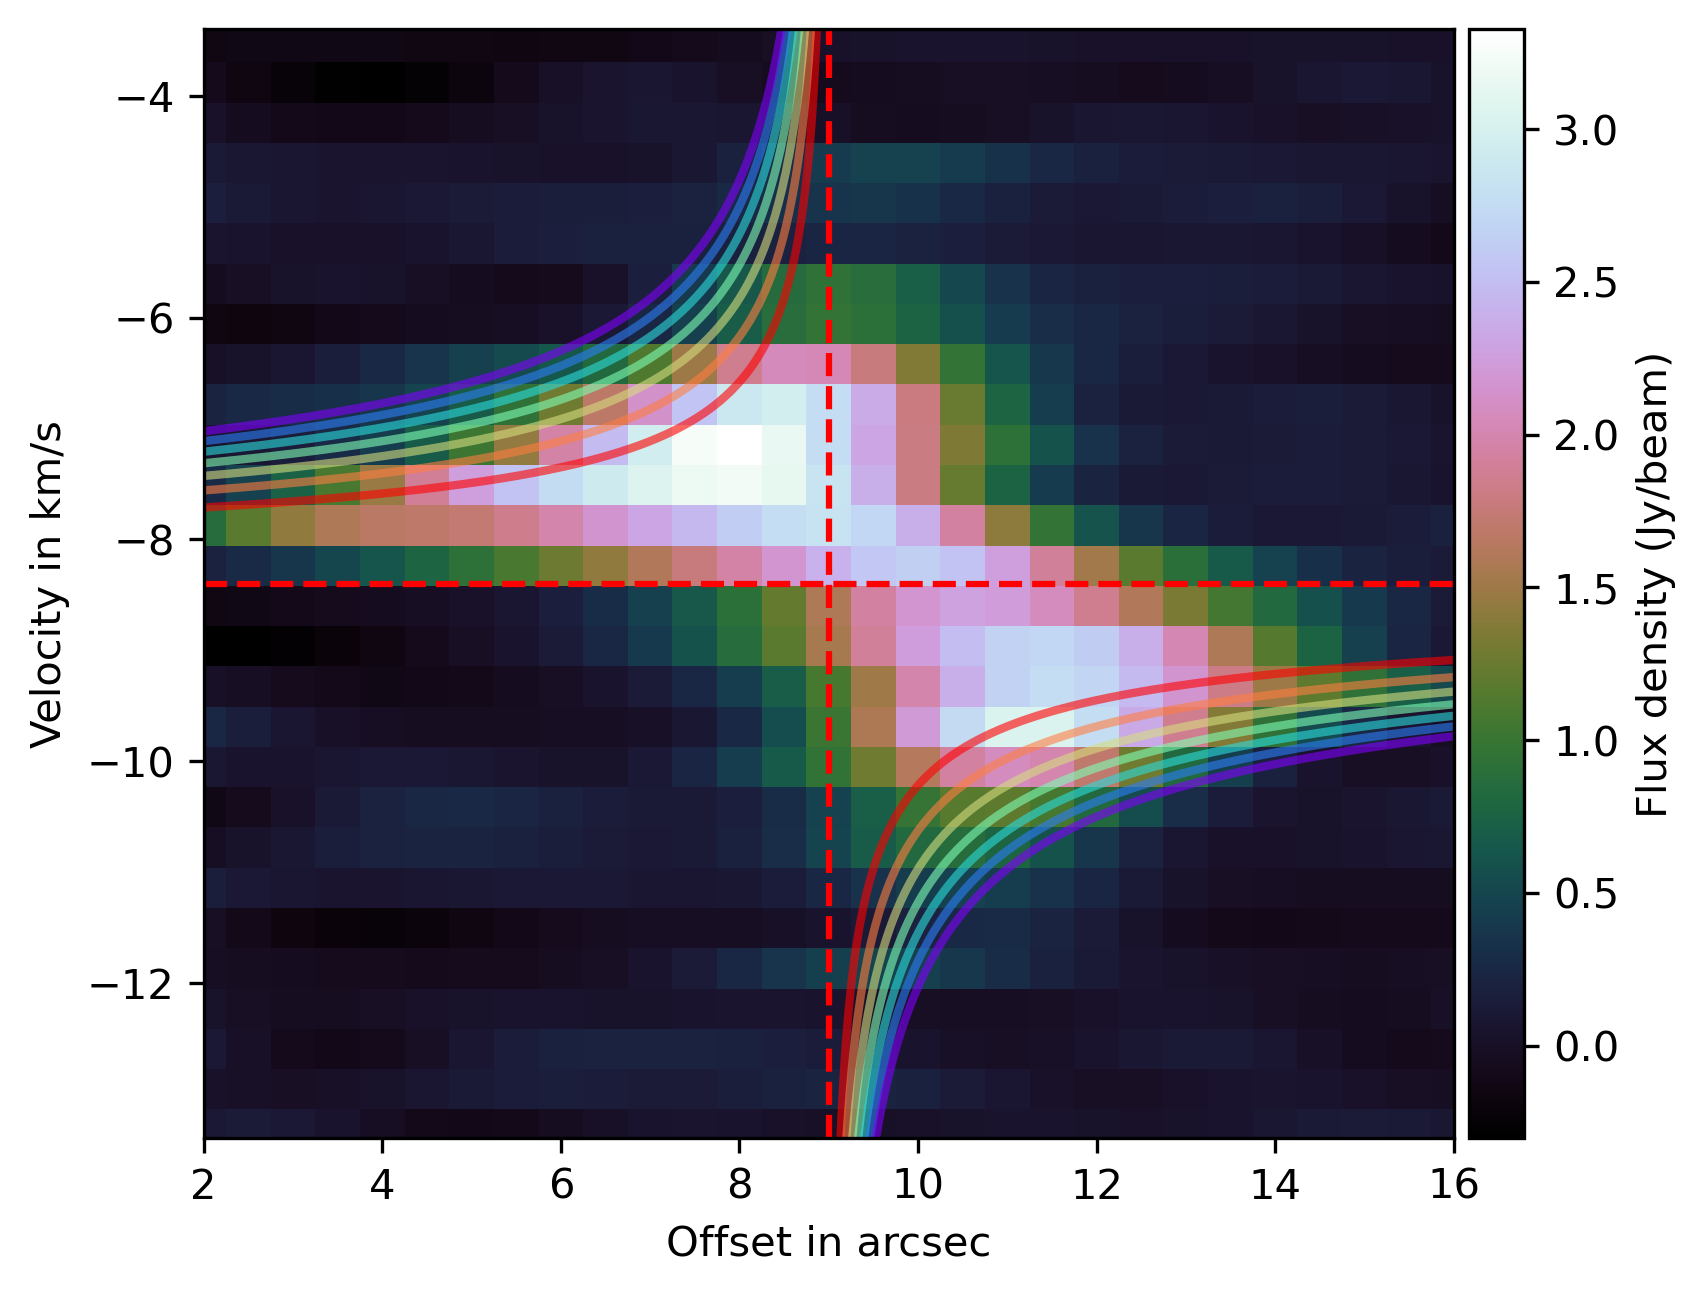

In [760]:
### 1 xpixel = 0.0001388888888889 deg
### 1 ypixel = -363.19867730252 m/s

v_sys = -8.4*u.km/u.s # got this value from eddy
x_offset = 9. #arcsec; length of the vector is 18 arcsec

x_arr = np.linspace(0,34,35)*0.0001388888888889*3600 # in arcsec
# y-Achse muss anhand der systemic velocity geshifted werden
y_arr = (np.linspace(0,59,60)*-363.19867730252+5201.6146231858)/1000. # in km/s

xi, yi = np.meshgrid(x_arr, y_arr)
zi = pvdiagram2.data

plt.figure(dpi=300)

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='cubehelix')

#plt.gca().invert_yaxis()

plt.xlabel('Offset in arcsec')
plt.ylabel('Velocity in km/s')

plt.axhline(v_sys.value, c='red', ls='--')
plt.axvline(x_offset, c='red', ls='--')

plt.ylim(v_sys.value-5,v_sys.value+5)
plt.xlim(x_offset-7,x_offset+7)

# rainbow_r colormap starts at red
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))
masses = np.arange(1,4.5,0.5)
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
for el in range(len(masses)):
    plt.plot(radii+x_offset, -kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, c=colors[el], alpha=0.6, lw=2)
    plt.plot(-radii+x_offset, kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, c=colors[el], alpha=0.6, lw=2)

cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=10)


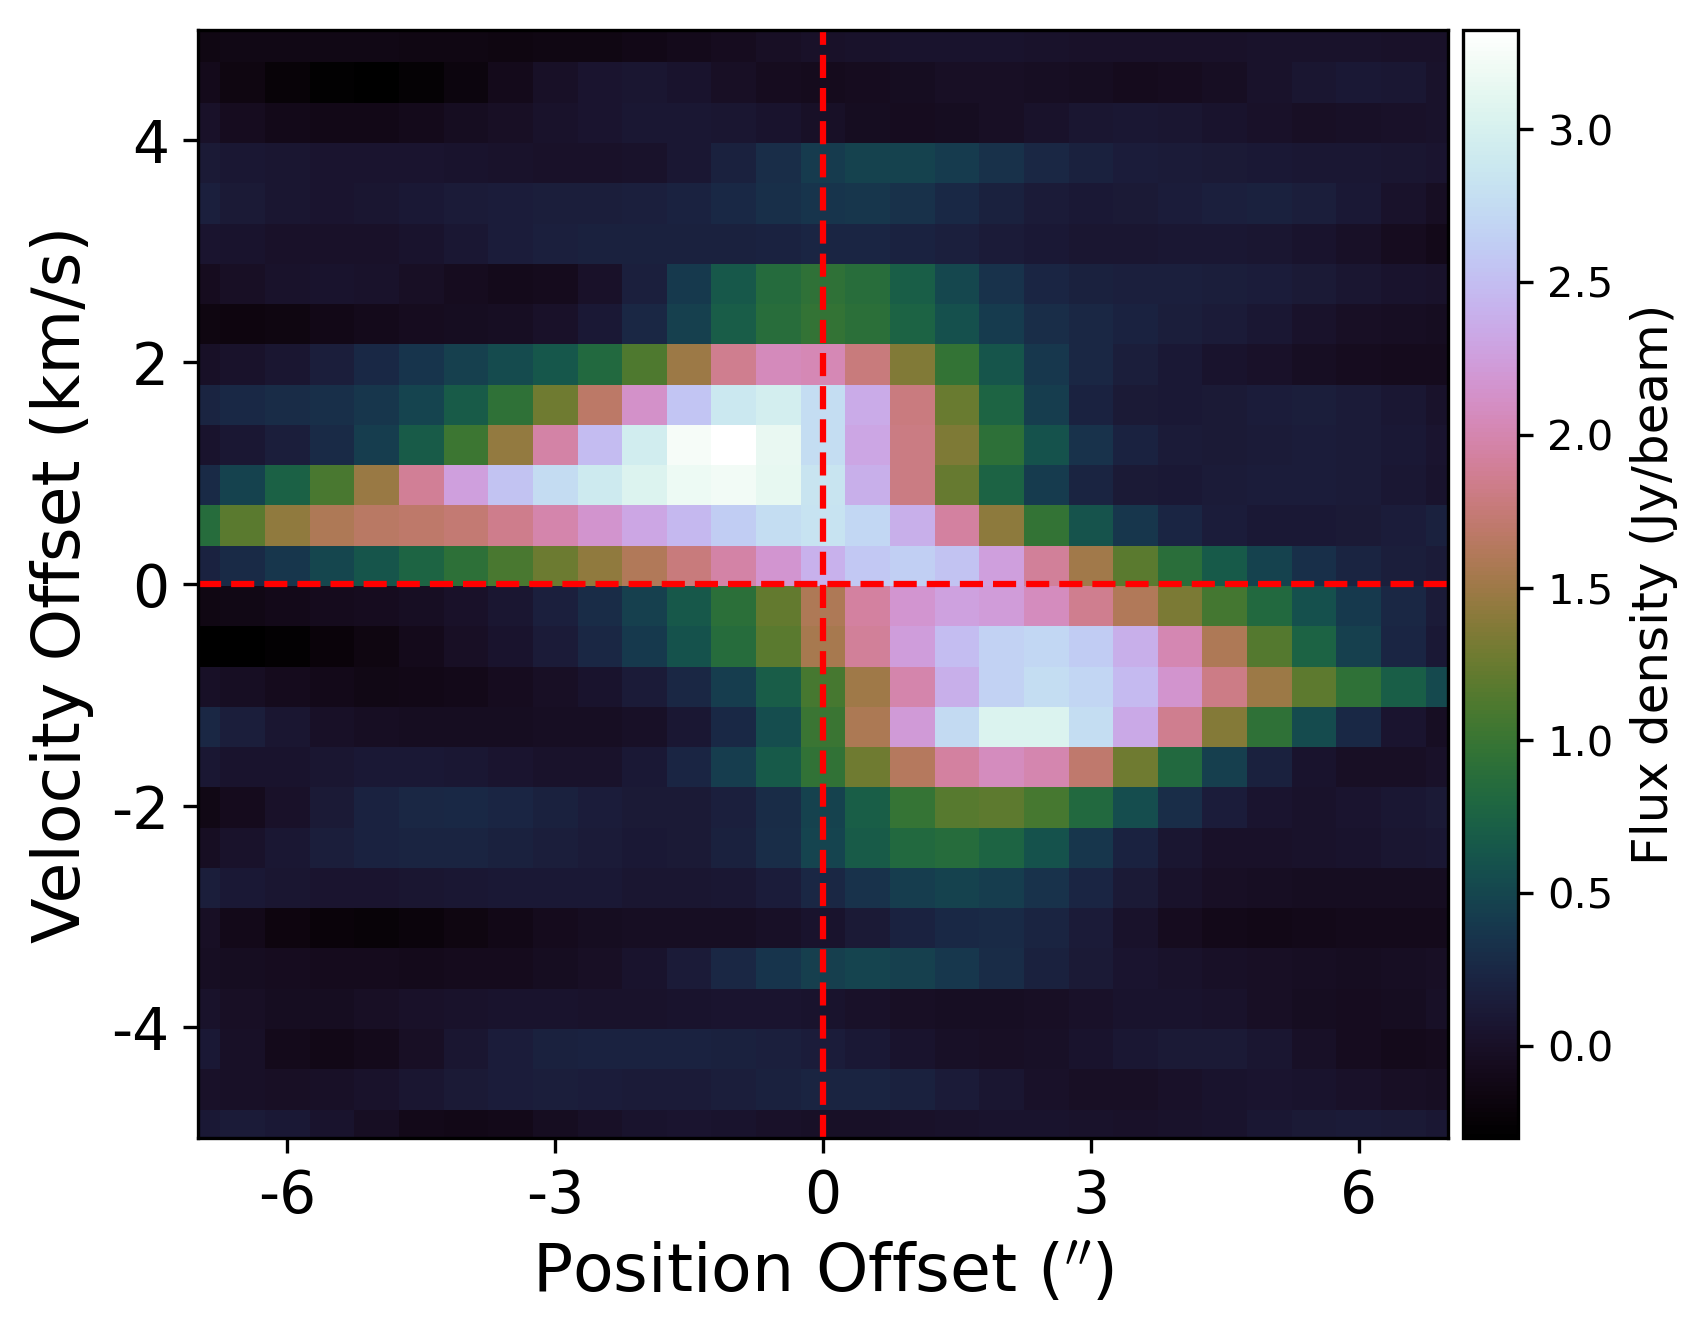

In [772]:
### 1 xpixel = 0.0001388888888889 deg
### 1 ypixel = -363.19867730252 m/s

v_sys = -8.4*u.km/u.s # got this value from eddy
x_offset = 9. #arcsec; length of the vector is 18 arcsec

x_arr = np.linspace(0,34,35)*0.0001388888888889*3600 # in arcsec
# y-Achse muss anhand der systemic velocity geshifted werden
y_arr = (np.linspace(0,59,60)*-363.19867730252+5201.6146231858)/1000. # in km/s

xi, yi = np.meshgrid(x_arr, y_arr)
zi = pvdiagram2.data

plt.figure(dpi=300)

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='cubehelix')

#plt.gca().invert_yaxis()

plt.xlabel("Position Offset ($''$)", fontsize=16)
plt.ylabel('Velocity Offset (km/s)', fontsize=16)

plt.axhline(v_sys.value, c='red', ls='--')
plt.axvline(x_offset, c='red', ls='--')

plt.ylim(v_sys.value-5,v_sys.value+5)
plt.xlim(x_offset-7,x_offset+7)

plt.xticks(np.arange(3,18,3), labels=['-6', '-3', '0', '3', '6'], fontsize=14)
plt.yticks([-12.4,-10.4, -8.4,-6.4,-4.4], labels=['-4', '-2', '0', '2', '4' ], fontsize=14)


# rainbow_r colormap starts at red
colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))
masses = np.arange(1,4.5,0.5)
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
#for el in range(len(masses)):
#    plt.plot(radii+x_offset, -kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, c=colors[el], alpha=0.6, lw=2)
#    plt.plot(-radii+x_offset, kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, c=colors[el], alpha=0.6, lw=2)

cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=12)


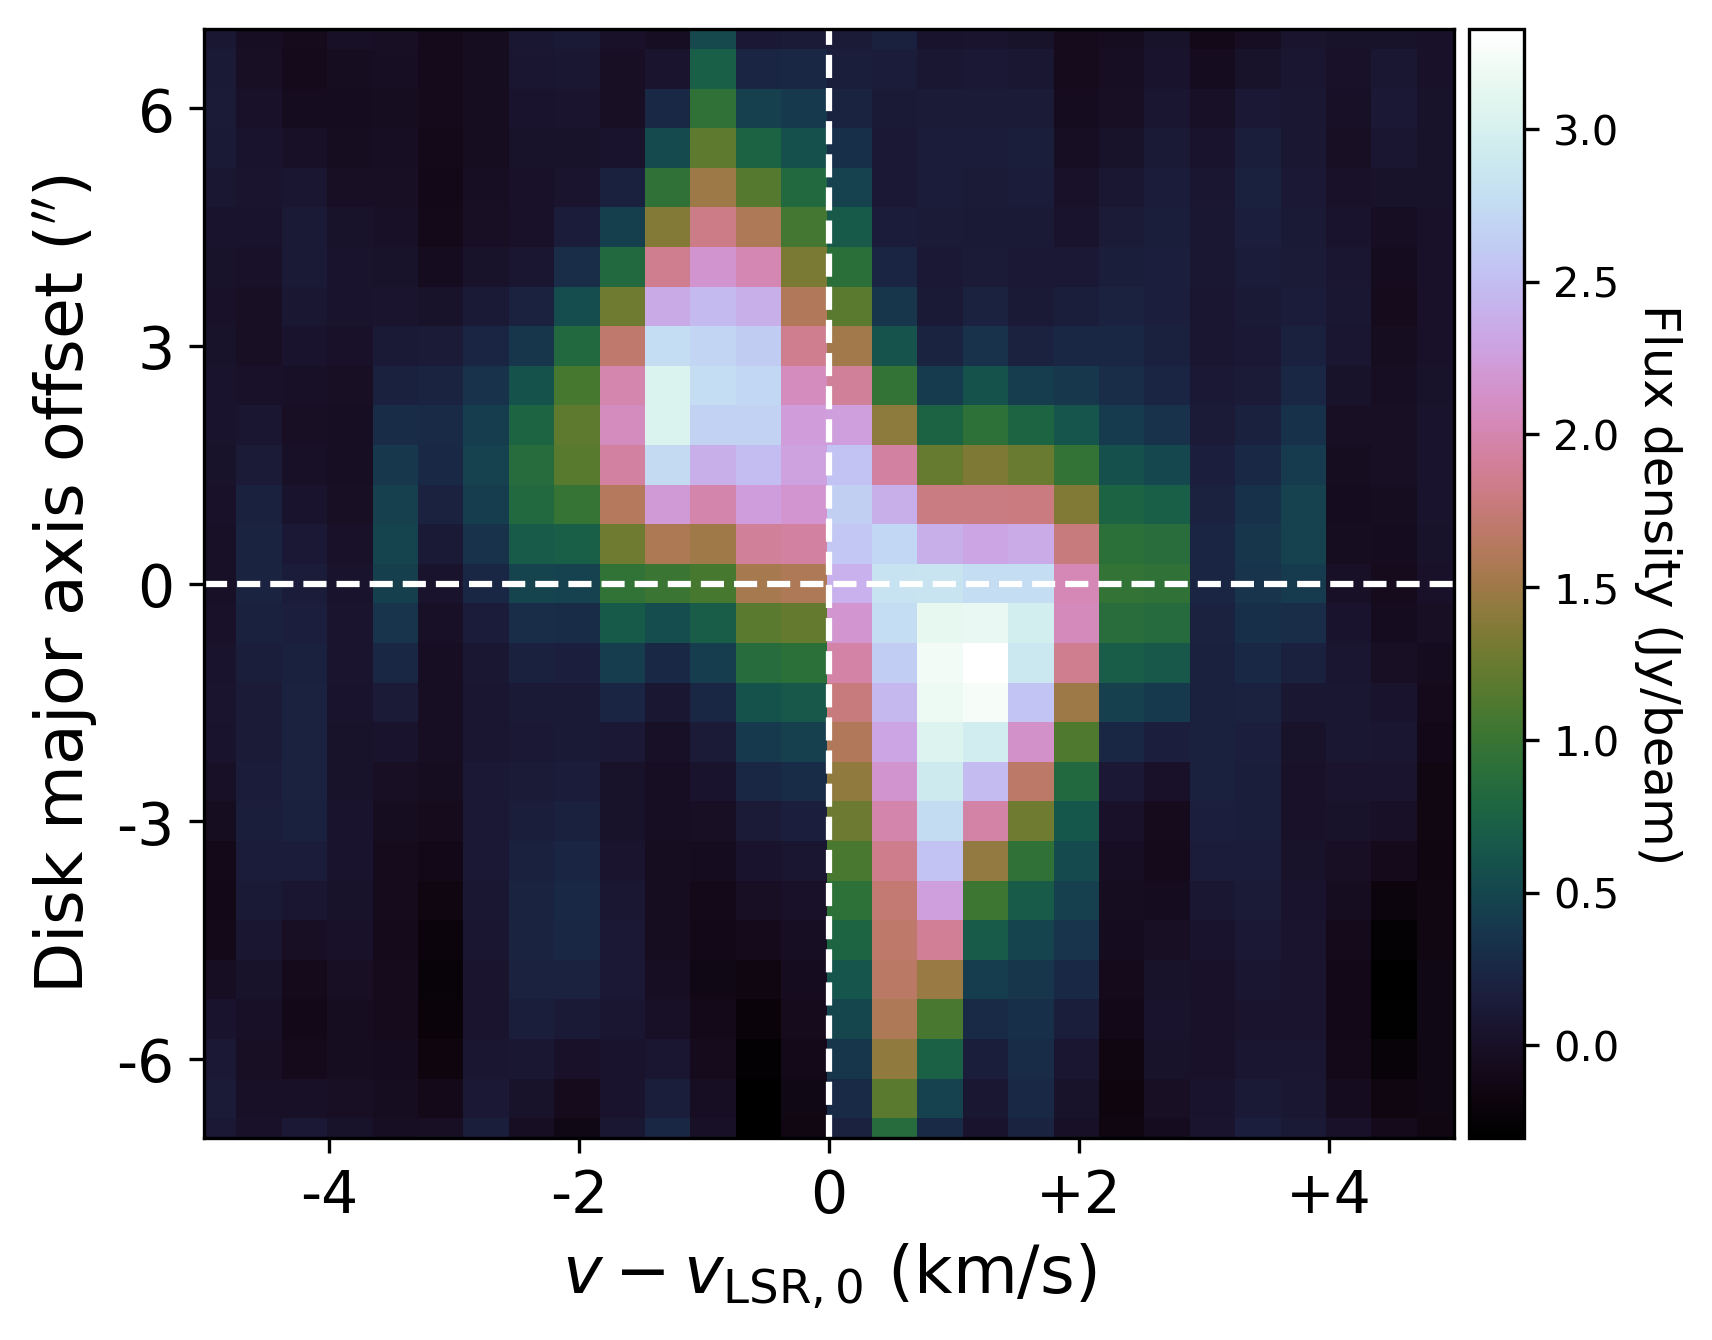

In [775]:
### 1 xpixel = 0.0001388888888889 deg
### 1 ypixel = -363.19867730252 m/s

v_sys = -8.4*u.km/u.s # got this value from eddy
x_offset = 9. #arcsec; length of the vector is 18 arcsec

x_arr = np.linspace(0,34,35)*0.0001388888888889*3600 # in arcsec
# y-Achse muss anhand der systemic velocity geshifted werden
y_arr = (np.linspace(0,59,60)*-363.19867730252+5201.6146231858)/1000. # in km/s

xi, yi = np.meshgrid(y_arr, x_arr)
zi = pvdiagram2.data.T

plt.figure(dpi=300)

plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='cubehelix')

plt.ylabel("Disk major axis offset ($''$)", fontsize=16)
plt.xlabel("$v-v_\mathrm{LSR,0}$ (km/s)", fontsize=16)

plt.axvline(v_sys.value, c='white', ls='--')
plt.axhline(x_offset, c='white', ls='--')

plt.xlim(v_sys.value+5,v_sys.value-5)
plt.ylim(x_offset-7,x_offset+7)

plt.yticks(np.arange(3,18,3), labels=['-6', '-3', '0', '3', '6'], fontsize=14)
plt.xticks([-4.4,-6.4, -8.4, -10.4, -12.4], labels=['+4', '+2', '0', '-2', '-4' ], fontsize=14)

plt.gca().invert_xaxis()

# rainbow_r colormap starts at red
colors = plt.cm.Greys_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))
masses = np.arange(1,4.5,0.5)
radii = np.linspace(0,20,1000) #arcsec

# overplot Kepler velocity profiles
#for el in range(len(masses)):
#    plt.plot(-kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, radii+x_offset, c=colors[el], alpha=0.6, lw=2)
#    plt.plot(kepler(mass=np.round(masses[el],2), radius=radii, distance=260., inclination=80.)+v_sys, -radii+x_offset, c=colors[el], alpha=0.6, lw=2)

cb = plt.colorbar(pad=0.01)
cb.set_label("Flux density (Jy/beam)", fontsize=12, rotation=270, labelpad=15)


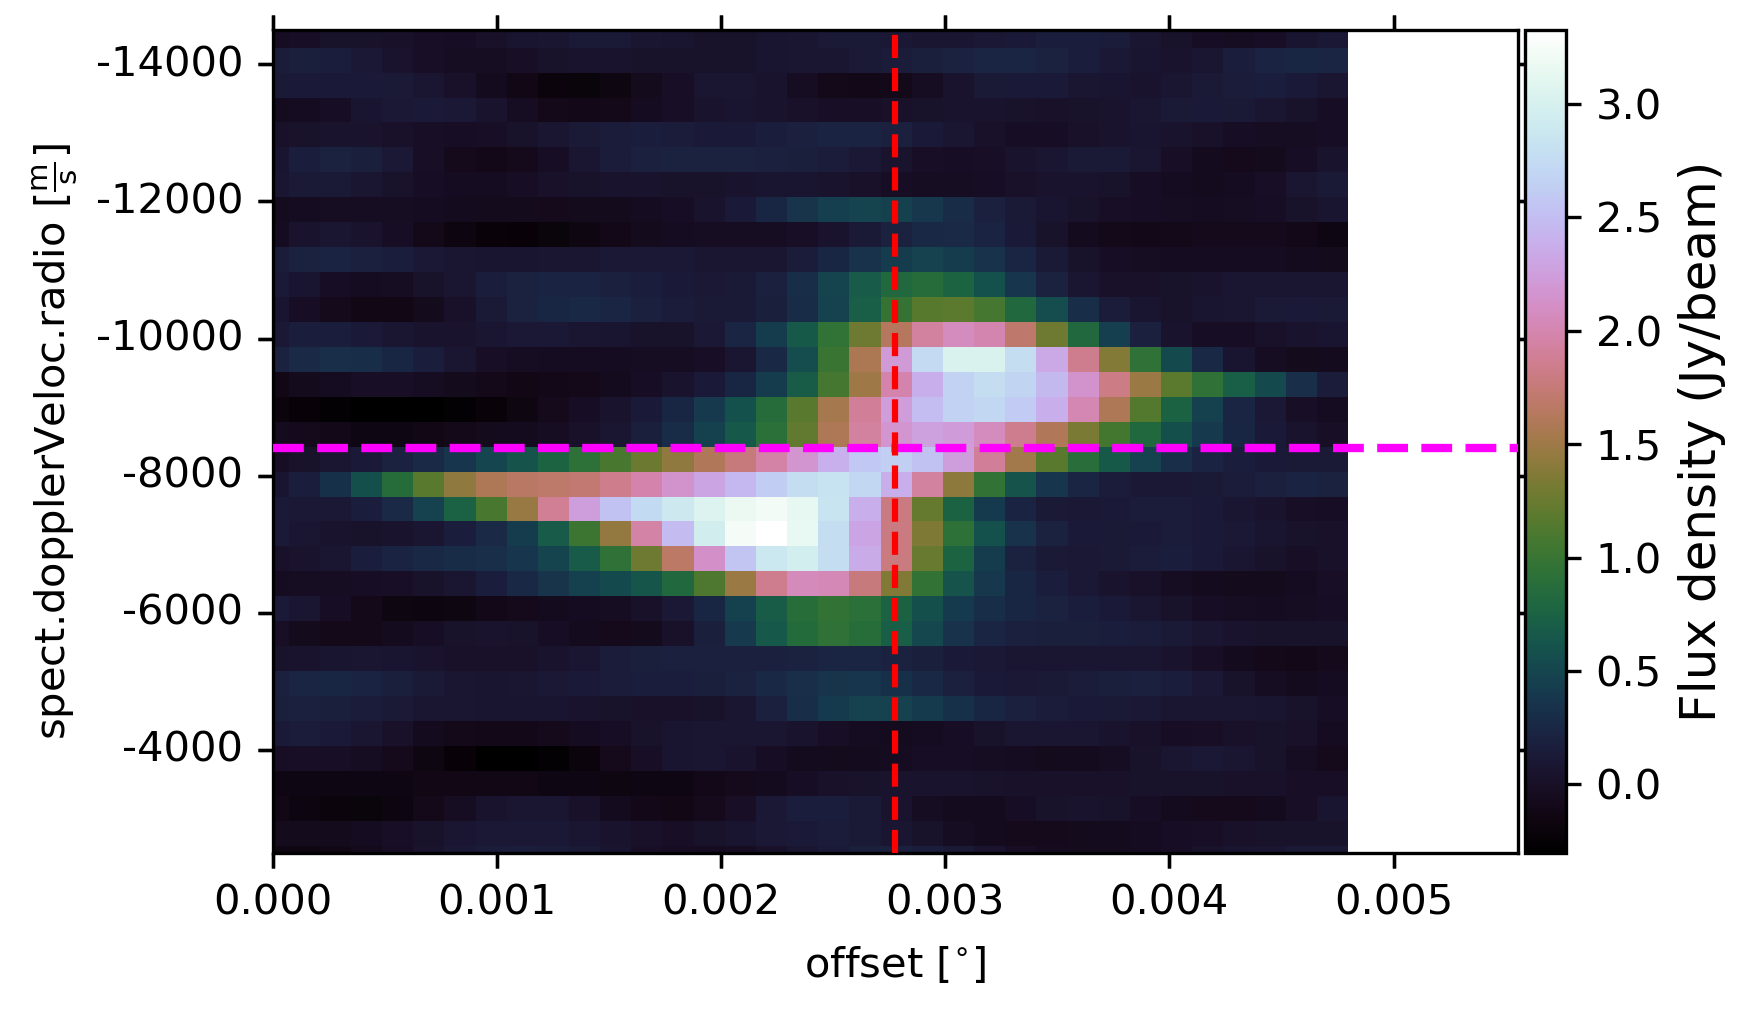

In [541]:
plt.figure(dpi=300)

ax = plt.subplot(111, projection=ww2)

im = ax.imshow(pvdiagram2.data, cmap='cubehelix')

ax0 = ax.coords[0]
#ax0.set_format_unit(u.arcsec)
ax1 = ax.coords[1]
#ax1.set_format_unit(u.km/u.s)


# aus irgendeinem Grund muss der Scheiß Faktor 2 noch dran
#ax0.set_ticks(values=np.array([0.001,0.002,0.003])/x_pixelscale_deg)
#ax0.set_ticks(values=np.array([0,5,10,15,20])/x_pixscale/60/60/2*u.deg)
#ax0.set_ticklabel(size=12)#(name=['a', 'a','a','a'], color='red')
#ax.tick_params(direction="in", color='white')





cb = plt.colorbar(mappable=im,fraction=0.0318, pad=0.005)
cb.set_label("Flux density (Jy/beam)", fontsize=12)
#ax.set_ylabel("Velocity (km/s)", fontsize=14)
#ax.set_xlabel("Offset ($''$)", fontsize=14)


y_zero = 5.2016146231858 # km/s
y_pixscale = 0.36319867699999997 # km/s per pixel
x_pixscale = 0.5 # arcsec per pixel
ax.set_xlim((10-10)/x_pixscale, (10+10)/x_pixscale)
ax.set_ylim((8.5-6)/y_pixscale+y_offset, (8.5+6)/y_pixscale+y_offset)
ax.set_aspect(0.8)

#ax.set_xticks(np.array([0,1,2,3,4])/x_pixscale, labels=['a', 'b', 'c', 'd', 'e'])


#ax0.set_ticklabel(np.array([0,1,2,3,4])/x_pixscale*u.arcsec)
#ax0.set_ticks(np.array([4,8,12,16]))
#ax0.set_ticks([60*u.deg])

#ax0.set_ticks((np.array([5, 10]))/x_pixscale*u.arcsec)

y_offset = y_zero/y_pixscale
x_offset = 10./x_pixscale

radii_pos = np.linspace(0,20,1000)
radii_pixelscale = radii_pos/x_pixscale


plt.axhline(-(v_sys.value/y_pixscale)+y_offset, c='magenta', ls='--', lw=2)
plt.axvline(x_offset, c='red', ls='--')



colors = plt.cm.rainbow_r(np.linspace(0, 1, len(np.arange(1,4.5,0.5))))

# rainbow_r colormap starts at red
masses = np.arange(1,4.5,0.5)
#or el in range(len(masses)):
#    ax.plot(radii_pixelscale+x_offset, -(v_sys.value/y_pixscale)+kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=260., inclination=80.).value/y_pixscale+y_offset, c=colors[el], alpha=0.3, lw=2)
#    ax.plot(-radii_pixelscale+x_offset, -(v_sys.value/y_pixscale)-kepler(mass=np.round(masses[el],2), radius=radii_pos, distance=260., inclination=80.).value/y_pixscale+y_offset, c=colors[el], alpha=0.3, lw=2)


plt.tight_layout()

#ax.set_ylim(23, 50)
#ax.axhline(40, c='white', lw=3, zorder=2)

## Get the pixel scales of the PV diagram

In [537]:
from astropy import wcs

# x-axis = offset in deg
# y-axis = velocity in m/s
ww2 = wcs.WCS(pvdiagram2)

wcs.utils.proj_plane_pixel_scales(ww2)
## 0.5 arcsec per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60)
x_pixelscale_arcsec = wcs.utils.proj_plane_pixel_scales(ww2)[0]*60*60
x_pixelscale_deg = wcs.utils.proj_plane_pixel_scales(ww2)[0]

## km/s per pixel
print(wcs.utils.proj_plane_pixel_scales(ww2)[1]/1000)

0.50000000000004
0.36319867730252003
